In [1]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
import math
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from dataset import get_dataset
from utils import alphabar_t
from model import Model
from generate import train_sample
import os

torch.backends.cudnn.benchmark = True


/home/bigbrainman/deepvenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
T = 35
S = 0.0008
BATCH_SIZE = 128

In [3]:
train_set = get_dataset(T)

Files already downloaded and verified


In [4]:
g = make_grid([train_set[random.randint(0, len(train_set) -1)][1] for _ in range(25)], 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


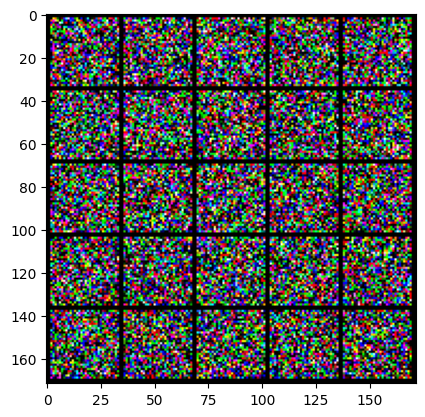

In [5]:
plt.imshow(g.permute(1, 2, 0))
print(train_set[0][0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


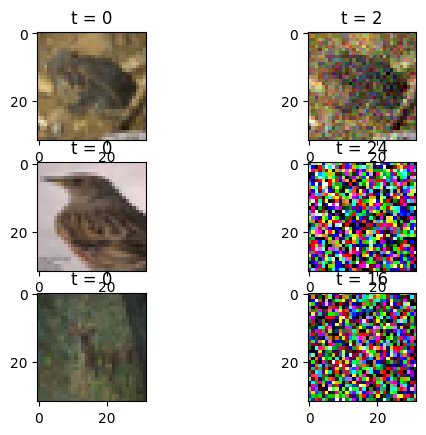

In [6]:
fig, axes = plt.subplots(3, 2)

for i in range(3):
    idx = random.randint(1, T - 1)
    axrow = axes[i]

    noise_img, eps, img, t = train_set[idx]

    axrow[0].imshow(img.permute(1, 2, 0), cmap='gray')
    axrow[0].set_title('t = 0')

    axrow[1].imshow(noise_img.permute(1, 2, 0), cmap='gray')
    axrow[1].set_title(f"t = {t}")

In [7]:
net = Model(u_depth = 5, block_size=3, h_channels = 10).to(device)

iters = 0

if os.path.exists('./models') and len(list(os.walk('./models'))[0][2]) >= 2:

    highest = 0
    for p in list(os.walk('./models'))[0][2]:
        
        highest = max(highest, int(os.path.splitext(p)[0]))

    print(f"loading {highest}")
    path = f'./models/{highest}.pth'
    print(path)
    net.load_state_dict(torch.load(path))
    iters = highest

summary(net, (3, 32, 32), device=device)

loading 400
./models/400.pth
no t
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
SinusoidalPositionEmbeddings-1                    [-1, 6]               0
SinusoidalPositionEmbeddings-2                    [-1, 6]               0
            Conv2d-3           [-1, 10, 32, 32]             280
            Linear-4                   [-1, 10]              70
            Conv2d-5           [-1, 10, 32, 32]             910
       BatchNorm2d-6           [-1, 10, 32, 32]              20
              ReLU-7           [-1, 10, 32, 32]               0
           Dropout-8           [-1, 10, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]             910
      BatchNorm2d-10           [-1, 10, 32, 32]              20
             ReLU-11           [-1, 10, 32, 32]               0
          Dropout-12           [-1, 10, 32, 32]               0
           Conv2d-13           [-1, 10, 32, 32]  

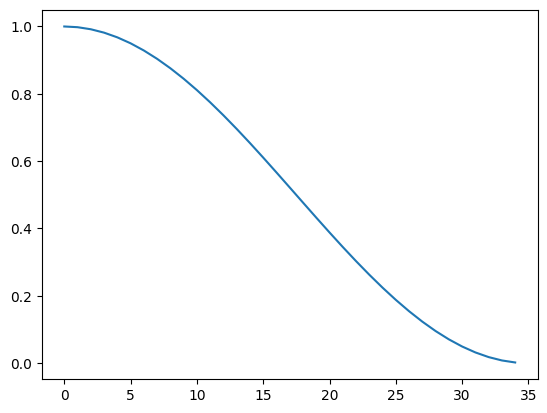

In [8]:
# precache the alpha_bars
a_bar = alphabar_t(torch.arange(0, T), T, S)

plt.plot(a_bar)


In [9]:
train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=0.0001, amsgrad=True)

In [11]:
iters_print = 20

iters_generate = 200


for i in range(100):
    print_loss = 0

    for noise_img, eps, img, t in train_dl:


        noise_img = noise_img.to(device)
        eps = eps.to(device)
        t = t.to(device)

        net.train()
        out = net(noise_img, t)

        loss = loss_fn(out, eps)

        optim.zero_grad()

        loss.backward()

        optim.step()

        print_loss += loss.item()


        iters += 1

        if iters % iters_print == 0:
            l = print_loss / iters_print
            print_loss = 0
            print(f"[iter {iters}] loss: {l}")


        if iters % iters_generate == 0:
            torch.save(net.state_dict(), f'./models/{iters}.pth')
            net.eval()
            with torch.no_grad():
                train_sample(20, T, net, iters, shape=(3, 32, 32))


[iter 420] loss: 0.7900658279657364
[iter 440] loss: 0.780059203505516
[iter 460] loss: 0.7688544631004334
[iter 480] loss: 0.7576806217432022
[iter 500] loss: 0.7492431074380874
[iter 520] loss: 0.7400250852108001
[iter 540] loss: 0.7315147429704666
[iter 560] loss: 0.7223105192184448
[iter 580] loss: 0.7142621010541916
[iter 600] loss: 0.7053717643022537


100%|██████████| 34/34 [00:00<00:00, 38.77it/s]


[iter 620] loss: 0.6979880541563034
[iter 640] loss: 0.6902612507343292
[iter 660] loss: 0.6835674613714218
[iter 680] loss: 0.6758748263120651
[iter 700] loss: 0.6695062577724457
[iter 720] loss: 0.6626550316810608
[iter 740] loss: 0.6570226222276687
[iter 760] loss: 0.6508196204900741
[iter 780] loss: 0.6456325799226761
[iter 800] loss: 0.2873298466205597


100%|██████████| 34/34 [00:00<00:00, 60.75it/s]


[iter 820] loss: 0.6336170971393585
[iter 840] loss: 0.6295652896165848
[iter 860] loss: 0.622686356306076
[iter 880] loss: 0.6194396644830704
[iter 900] loss: 0.6141674757003784
[iter 920] loss: 0.6090333312749863
[iter 940] loss: 0.6050607264041901
[iter 960] loss: 0.600991377234459
[iter 980] loss: 0.5958627104759217
[iter 1000] loss: 0.5921254605054855


100%|██████████| 34/34 [00:00<00:00, 62.09it/s]


[iter 1020] loss: 0.5879525482654572
[iter 1040] loss: 0.5852410614490509
[iter 1060] loss: 0.580912834405899
[iter 1080] loss: 0.5762453019618988
[iter 1100] loss: 0.5724747240543365
[iter 1120] loss: 0.5679644823074341
[iter 1140] loss: 0.5645765125751495
[iter 1160] loss: 0.5610472947359085
[iter 1180] loss: 0.5584983944892883
[iter 1200] loss: 0.49979694485664367


100%|██████████| 34/34 [00:00<00:00, 61.42it/s]


[iter 1220] loss: 0.5514251798391342
[iter 1240] loss: 0.5476336717605591
[iter 1260] loss: 0.543525442481041
[iter 1280] loss: 0.5401446282863617
[iter 1300] loss: 0.5396151185035706
[iter 1320] loss: 0.5345044136047363
[iter 1340] loss: 0.5329713821411133
[iter 1360] loss: 0.5286083310842514
[iter 1380] loss: 0.5265579253435135
[iter 1400] loss: 0.5241592049598693


100%|██████████| 34/34 [00:00<00:00, 61.97it/s]


[iter 1420] loss: 0.5228402733802795
[iter 1440] loss: 0.5210533201694488
[iter 1460] loss: 0.5154771357774734
[iter 1480] loss: 0.5139976173639298
[iter 1500] loss: 0.5122249960899353
[iter 1520] loss: 0.5110546380281449
[iter 1540] loss: 0.506325812637806
[iter 1560] loss: 0.5053689241409302
[iter 1580] loss: 0.1759761765599251
[iter 1600] loss: 0.5006967052817345


100%|██████████| 34/34 [00:00<00:00, 60.80it/s]


[iter 1620] loss: 0.5014008060097694
[iter 1640] loss: 0.4978815332055092
[iter 1660] loss: 0.4952835485339165
[iter 1680] loss: 0.49272809028625486
[iter 1700] loss: 0.49107807129621506
[iter 1720] loss: 0.48892711848020554
[iter 1740] loss: 0.4881028443574905
[iter 1760] loss: 0.48571508675813674
[iter 1780] loss: 0.48371664732694625
[iter 1800] loss: 0.48217720687389376


100%|██████████| 34/34 [00:00<00:00, 61.44it/s]


[iter 1820] loss: 0.4813996061682701
[iter 1840] loss: 0.4789185807108879
[iter 1860] loss: 0.47645090967416764
[iter 1880] loss: 0.4738709941506386
[iter 1900] loss: 0.47372142821550367
[iter 1920] loss: 0.47175078839063644
[iter 1940] loss: 0.4685804098844528
[iter 1960] loss: 0.4688189387321472
[iter 1980] loss: 0.37474521398544314
[iter 2000] loss: 0.46190925091505053


100%|██████████| 34/34 [00:00<00:00, 62.30it/s]


[iter 2020] loss: 0.46163454055786135
[iter 2040] loss: 0.4597495585680008
[iter 2060] loss: 0.4567418068647385
[iter 2080] loss: 0.45629774034023285
[iter 2100] loss: 0.45396762937307356
[iter 2120] loss: 0.4533416941761971
[iter 2140] loss: 0.45038517415523527
[iter 2160] loss: 0.45143502205610275
[iter 2180] loss: 0.44914115518331527
[iter 2200] loss: 0.44657657146453855


100%|██████████| 34/34 [00:00<00:00, 61.51it/s]


[iter 2220] loss: 0.44512302428483963
[iter 2240] loss: 0.4412041887640953
[iter 2260] loss: 0.4407240152359009
[iter 2280] loss: 0.44025697708129885
[iter 2300] loss: 0.44166913330554963
[iter 2320] loss: 0.43810243010520933
[iter 2340] loss: 0.4387459620833397
[iter 2360] loss: 0.10873108208179474
[iter 2380] loss: 0.43322030305862425
[iter 2400] loss: 0.43414659798145294


100%|██████████| 34/34 [00:00<00:00, 61.17it/s]


[iter 2420] loss: 0.4324721544981003
[iter 2440] loss: 0.43003724962472917
[iter 2460] loss: 0.4317073255777359
[iter 2480] loss: 0.4298431098461151
[iter 2500] loss: 0.42898781299591066
[iter 2520] loss: 0.42650334984064103
[iter 2540] loss: 0.42700750231742857
[iter 2560] loss: 0.4251162648200989
[iter 2580] loss: 0.4247859865427017
[iter 2600] loss: 0.4244950234889984


100%|██████████| 34/34 [00:00<00:00, 61.50it/s]


[iter 2620] loss: 0.4205877661705017
[iter 2640] loss: 0.42250831723213195
[iter 2660] loss: 0.42119649797677994
[iter 2680] loss: 0.4218182235956192
[iter 2700] loss: 0.4201718643307686
[iter 2720] loss: 0.4186468094587326
[iter 2740] loss: 0.4199206680059433
[iter 2760] loss: 0.29367175698280334
[iter 2780] loss: 0.41691998541355135
[iter 2800] loss: 0.41653748899698256


100%|██████████| 34/34 [00:00<00:00, 61.12it/s]


[iter 2820] loss: 0.4160501599311829
[iter 2840] loss: 0.41637961119413375
[iter 2860] loss: 0.4149829402565956
[iter 2880] loss: 0.4132866635918617
[iter 2900] loss: 0.4137939795851707
[iter 2920] loss: 0.41325327306985854
[iter 2940] loss: 0.4106295213103294
[iter 2960] loss: 0.4104069352149963
[iter 2980] loss: 0.4111547634005547
[iter 3000] loss: 0.41036505699157716


100%|██████████| 34/34 [00:00<00:00, 61.79it/s]


[iter 3020] loss: 0.40886589586734773
[iter 3040] loss: 0.4102436274290085
[iter 3060] loss: 0.40967574119567873
[iter 3080] loss: 0.4080591112375259
[iter 3100] loss: 0.4083537936210632
[iter 3120] loss: 0.4086350589990616
[iter 3140] loss: 0.06182986199855804
[iter 3160] loss: 0.4079875499010086
[iter 3180] loss: 0.40637148171663284
[iter 3200] loss: 0.40622819364070895


100%|██████████| 34/34 [00:00<00:00, 61.37it/s]


[iter 3220] loss: 0.40462164431810377
[iter 3240] loss: 0.40389943718910215
[iter 3260] loss: 0.4077774688601494
[iter 3280] loss: 0.403961269557476
[iter 3300] loss: 0.40398732125759124
[iter 3320] loss: 0.4029677748680115
[iter 3340] loss: 0.4003524467349052
[iter 3360] loss: 0.40381103456020356
[iter 3380] loss: 0.4010068967938423
[iter 3400] loss: 0.4022722080349922


100%|██████████| 34/34 [00:00<00:00, 60.42it/s]


[iter 3420] loss: 0.4003292918205261
[iter 3440] loss: 0.40191667526960373
[iter 3460] loss: 0.4009591966867447
[iter 3480] loss: 0.399890111386776
[iter 3500] loss: 0.39761894643306733
[iter 3520] loss: 0.3988525256514549
[iter 3540] loss: 0.23893357515335084
[iter 3560] loss: 0.39711888283491137
[iter 3580] loss: 0.3965399473905563
[iter 3600] loss: 0.39922387301921847


100%|██████████| 34/34 [00:00<00:00, 60.86it/s]


[iter 3620] loss: 0.3974177673459053
[iter 3640] loss: 0.3994535356760025
[iter 3660] loss: 0.39440048933029176
[iter 3680] loss: 0.3946161508560181
[iter 3700] loss: 0.39457634687423704
[iter 3720] loss: 0.39547495990991594
[iter 3740] loss: 0.39319519847631457
[iter 3760] loss: 0.395573316514492
[iter 3780] loss: 0.3959572330117226
[iter 3800] loss: 0.3953425109386444


100%|██████████| 34/34 [00:00<00:00, 60.79it/s]


[iter 3820] loss: 0.39601110816001894
[iter 3840] loss: 0.3931194141507149
[iter 3860] loss: 0.3927666038274765
[iter 3880] loss: 0.3895948320627213
[iter 3900] loss: 0.39222856760025027
[iter 3920] loss: 0.019818532466888427
[iter 3940] loss: 0.39246124774217606
[iter 3960] loss: 0.39096762984991074
[iter 3980] loss: 0.3915267184376717
[iter 4000] loss: 0.39240046590566635


100%|██████████| 34/34 [00:00<00:00, 60.73it/s]


[iter 4020] loss: 0.3893029808998108
[iter 4040] loss: 0.3899489462375641
[iter 4060] loss: 0.38878011256456374
[iter 4080] loss: 0.3883520901203156
[iter 4100] loss: 0.38731579631567004
[iter 4120] loss: 0.38903244733810427
[iter 4140] loss: 0.3881239503622055
[iter 4160] loss: 0.38893489092588424
[iter 4180] loss: 0.38727093040943145
[iter 4200] loss: 0.3887030690908432


100%|██████████| 34/34 [00:00<00:00, 60.48it/s]


[iter 4220] loss: 0.3892477676272392
[iter 4240] loss: 0.38773930370807647
[iter 4260] loss: 0.38875393718481066
[iter 4280] loss: 0.38827456533908844
[iter 4300] loss: 0.3899504393339157
[iter 4320] loss: 0.19210960417985917
[iter 4340] loss: 0.385011725127697
[iter 4360] loss: 0.3858052358031273
[iter 4380] loss: 0.3840900257229805
[iter 4400] loss: 0.38645640164613726


100%|██████████| 34/34 [00:00<00:00, 61.04it/s]


[iter 4420] loss: 0.38558188527822496
[iter 4440] loss: 0.3854359477758408
[iter 4460] loss: 0.3850883424282074
[iter 4480] loss: 0.386359378695488
[iter 4500] loss: 0.38181840628385544
[iter 4520] loss: 0.38317870944738386
[iter 4540] loss: 0.38344549387693405
[iter 4560] loss: 0.3843309834599495
[iter 4580] loss: 0.382864785194397
[iter 4600] loss: 0.38182263523340226


100%|██████████| 34/34 [00:00<00:00, 61.02it/s]


[iter 4620] loss: 0.38275952637195587
[iter 4640] loss: 0.380126616358757
[iter 4660] loss: 0.385321281850338
[iter 4680] loss: 0.3821397289633751
[iter 4700] loss: 0.3836039513349533
[iter 4720] loss: 0.3622205078601837
[iter 4740] loss: 0.3839016601443291
[iter 4760] loss: 0.3808962479233742
[iter 4780] loss: 0.37962195575237273
[iter 4800] loss: 0.38092283606529237


100%|██████████| 34/34 [00:00<00:00, 61.17it/s]


[iter 4820] loss: 0.38256261944770814
[iter 4840] loss: 0.3805270314216614
[iter 4860] loss: 0.37833802700042723
[iter 4880] loss: 0.37877275198698046
[iter 4900] loss: 0.38058932274580004
[iter 4920] loss: 0.3810023695230484
[iter 4940] loss: 0.3785763829946518
[iter 4960] loss: 0.3790636658668518
[iter 4980] loss: 0.3792491525411606
[iter 5000] loss: 0.37819315046072005


100%|██████████| 34/34 [00:00<00:00, 61.45it/s]


[iter 5020] loss: 0.37668411880731584
[iter 5040] loss: 0.37973122149705885
[iter 5060] loss: 0.3784477710723877
[iter 5080] loss: 0.376980884373188
[iter 5100] loss: 0.1505329743027687
[iter 5120] loss: 0.3779985845088959
[iter 5140] loss: 0.3757959917187691
[iter 5160] loss: 0.379607555270195
[iter 5180] loss: 0.37512521296739576
[iter 5200] loss: 0.3745622679591179


100%|██████████| 34/34 [00:00<00:00, 61.19it/s]


[iter 5220] loss: 0.3759234309196472
[iter 5240] loss: 0.3736045196652412
[iter 5260] loss: 0.3751944601535797
[iter 5280] loss: 0.37357207685709
[iter 5300] loss: 0.3755568191409111
[iter 5320] loss: 0.37659056931734086
[iter 5340] loss: 0.37370904088020324
[iter 5360] loss: 0.3748750776052475
[iter 5380] loss: 0.37591378539800646
[iter 5400] loss: 0.3734333723783493


100%|██████████| 34/34 [00:00<00:00, 60.64it/s]


[iter 5420] loss: 0.3759593218564987
[iter 5440] loss: 0.3744567736983299
[iter 5460] loss: 0.3737710744142532
[iter 5480] loss: 0.37237963974475863
[iter 5500] loss: 0.3183990940451622
[iter 5520] loss: 0.3721500769257545
[iter 5540] loss: 0.37305160611867905
[iter 5560] loss: 0.3732572212815285
[iter 5580] loss: 0.3746974140405655
[iter 5600] loss: 0.3721733182668686


100%|██████████| 34/34 [00:00<00:00, 60.58it/s]


[iter 5620] loss: 0.3736955150961876
[iter 5640] loss: 0.36921690255403516
[iter 5660] loss: 0.3740685999393463
[iter 5680] loss: 0.37361867278814315
[iter 5700] loss: 0.3732985436916351
[iter 5720] loss: 0.3725718766450882
[iter 5740] loss: 0.3705866575241089
[iter 5760] loss: 0.3710095539689064
[iter 5780] loss: 0.370346362888813
[iter 5800] loss: 0.3715526729822159


100%|██████████| 34/34 [00:00<00:00, 61.01it/s]


[iter 5820] loss: 0.37142381221055987
[iter 5840] loss: 0.36972927749156953
[iter 5860] loss: 0.3696545839309692
[iter 5880] loss: 0.11147632598876953
[iter 5900] loss: 0.3713261350989342
[iter 5920] loss: 0.3671535819768906
[iter 5940] loss: 0.37362355887889864
[iter 5960] loss: 0.3683787375688553
[iter 5980] loss: 0.37037263959646227
[iter 6000] loss: 0.369372133910656


100%|██████████| 34/34 [00:00<00:00, 60.42it/s]


[iter 6020] loss: 0.3705716237425804
[iter 6040] loss: 0.36878674328327177
[iter 6060] loss: 0.3683474361896515
[iter 6080] loss: 0.36963137686252595
[iter 6100] loss: 0.3666188508272171
[iter 6120] loss: 0.3690420642495155
[iter 6140] loss: 0.36704881936311723
[iter 6160] loss: 0.3680216699838638
[iter 6180] loss: 0.3692325636744499
[iter 6200] loss: 0.3686541974544525


100%|██████████| 34/34 [00:00<00:00, 60.65it/s]


[iter 6220] loss: 0.3675986468791962
[iter 6240] loss: 0.36988401412963867
[iter 6260] loss: 0.36900304555892943
[iter 6280] loss: 0.2760163426399231
[iter 6300] loss: 0.3691357523202896
[iter 6320] loss: 0.3659094452857971
[iter 6340] loss: 0.36725110560655594
[iter 6360] loss: 0.3652435585856438
[iter 6380] loss: 0.3668744832277298
[iter 6400] loss: 0.3666665777564049


100%|██████████| 34/34 [00:00<00:00, 60.88it/s]


[iter 6420] loss: 0.36662947535514834
[iter 6440] loss: 0.36689404845237733
[iter 6460] loss: 0.3669216439127922
[iter 6480] loss: 0.36787448078393936
[iter 6500] loss: 0.36483039408922197
[iter 6520] loss: 0.3629553705453873
[iter 6540] loss: 0.36512240916490557
[iter 6560] loss: 0.3645263612270355
[iter 6580] loss: 0.3662605628371239
[iter 6600] loss: 0.36284255385398867


100%|██████████| 34/34 [00:00<00:00, 60.95it/s]


[iter 6620] loss: 0.3638625741004944
[iter 6640] loss: 0.3663707196712494
[iter 6660] loss: 0.07286263555288315
[iter 6680] loss: 0.3632321983575821
[iter 6700] loss: 0.36281668990850446
[iter 6720] loss: 0.36472339928150177
[iter 6740] loss: 0.3632893353700638
[iter 6760] loss: 0.3609138146042824
[iter 6780] loss: 0.3626128390431404
[iter 6800] loss: 0.36433156579732895


100%|██████████| 34/34 [00:00<00:00, 60.41it/s]


[iter 6820] loss: 0.3638062566518784
[iter 6840] loss: 0.3630038559436798
[iter 6860] loss: 0.36083362698554994
[iter 6880] loss: 0.36201289147138593
[iter 6900] loss: 0.36222877353429794
[iter 6920] loss: 0.3613376244902611
[iter 6940] loss: 0.36193215996026995
[iter 6960] loss: 0.36390123814344405
[iter 6980] loss: 0.3632580190896988
[iter 7000] loss: 0.3622227281332016


100%|██████████| 34/34 [00:00<00:00, 60.67it/s]


[iter 7020] loss: 0.36188842356204987
[iter 7040] loss: 0.36071208119392395
[iter 7060] loss: 0.23604739904403688
[iter 7080] loss: 0.36115346699953077
[iter 7100] loss: 0.36043860763311386
[iter 7120] loss: 0.3621294304728508
[iter 7140] loss: 0.36029560714960096
[iter 7160] loss: 0.36065748929977415
[iter 7180] loss: 0.35958258956670763
[iter 7200] loss: 0.36006841957569125


100%|██████████| 34/34 [00:00<00:00, 60.90it/s]


[iter 7220] loss: 0.36050417125225065
[iter 7240] loss: 0.3602156758308411
[iter 7260] loss: 0.3622743770480156
[iter 7280] loss: 0.36006255745887755
[iter 7300] loss: 0.35549532175064086
[iter 7320] loss: 0.3584270283579826
[iter 7340] loss: 0.35924090892076493
[iter 7360] loss: 0.3620992749929428
[iter 7380] loss: 0.35762332677841185
[iter 7400] loss: 0.35677458345890045


100%|██████████| 34/34 [00:00<00:00, 61.28it/s]


[iter 7420] loss: 0.3591060310602188
[iter 7440] loss: 0.03629339635372162
[iter 7460] loss: 0.35851662755012514
[iter 7480] loss: 0.3603579983115196
[iter 7500] loss: 0.36174854934215545
[iter 7520] loss: 0.3572716012597084
[iter 7540] loss: 0.3584425151348114
[iter 7560] loss: 0.35968249291181564
[iter 7580] loss: 0.3597253397107124
[iter 7600] loss: 0.3577612653374672


100%|██████████| 34/34 [00:00<00:00, 60.65it/s]


[iter 7620] loss: 0.357784640789032
[iter 7640] loss: 0.3587485566735268
[iter 7660] loss: 0.36034662276506424
[iter 7680] loss: 0.35734466165304185
[iter 7700] loss: 0.3560964196920395
[iter 7720] loss: 0.3585919126868248
[iter 7740] loss: 0.35700967013835905
[iter 7760] loss: 0.35539858788251877
[iter 7780] loss: 0.3594816729426384
[iter 7800] loss: 0.3583387941122055


100%|██████████| 34/34 [00:00<00:00, 60.89it/s]


[iter 7820] loss: 0.3586979314684868
